In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy

In [2]:
class GenericGRU(nn.Module):
    def __init__(self, H_no, E_no, I_no, sub_no, device):
        super().__init__()
        
        self.H_no = H_no
        self.device = device
        self.sub_no = sub_no
        self.E_no = E_no
        self.I_no = I_no
        
        self.E_scale = nn.Parameter(torch.zeros(self.E_no), requires_grad=True)
        self.I_scale = nn.Parameter(torch.zeros(self.I_no), requires_grad=True)
        
        self.rnn = nn.ModuleList()
        self.linear = nn.ModuleList()
        for s in range(self.sub_no):
            self.rnn.append(nn.GRU(1, self.H_no, batch_first=True))
            self.linear.append(nn.Linear(self.H_no, 1))
            
        self.C_syn_e_raw = nn.Parameter(torch.zeros(sub_no, E_no))
        self.C_syn_i_raw = nn.Parameter(torch.zeros(sub_no, I_no))
        
    def forward(self, S_e, S_i, temp):
        T_data = S_e.shape[1]
        batch_size = S_e.shape[0]
        S_e = S_e * torch.exp(self.E_scale.reshape(1,1,-1))
        S_i = S_i * torch.exp(self.I_scale.reshape(1,1,-1))*(-1)
        
        C_syn_e = F.softmax(self.C_syn_e_raw/temp, 0)
        C_syn_i = F.softmax(self.C_syn_i_raw/temp, 0)
        
        S_e_sub = torch.matmul(S_e, C_syn_e.T.unsqueeze(0))
        S_i_sub = torch.matmul(S_i, C_syn_i.T.unsqueeze(0))
        S_sub = S_e_sub + S_i_sub
        
        sub_out = torch.zeros(batch_size, T_data, self.sub_no).to(self.device)
        
        for s in range(self.sub_no):
            rnn_out, _ = self.rnn[s](S_sub[:,:,s].unsqueeze(2))
            lin_out = self.linear[s](rnn_out.reshape(-1,self.H_no)).reshape(batch_size, T_data)
            sub_out[:,:,s] = sub_out[:,:,s] + lin_out     
        final = torch.sum(sub_out, 2)
        
        return final, sub_out, C_syn_e, C_syn_i


In [3]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"
V_file = "V_diff.npy"
eloc_file = "Elocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
iloc_file = "Ilocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
V = torch.from_numpy(V)
eloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+eloc_file)
iloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+iloc_file)

den_idx = np.unique(eloc[880:1120,0])
e_idx = np.where(np.isin(eloc[:,0], den_idx) == True)[0]
i_idx = np.where(np.isin(iloc[:,0], den_idx) == True)[0]
e_idx = torch.from_numpy(e_idx)
i_idx = torch.from_numpy(i_idx)

In [4]:
T_train = 992 * 1000 * 50
T_test = 1 * 1000 * 50
H_no = 10
layer_no = 1
sub_no = 4
E_no = 2000
I_no = 200
device = torch.device("cuda")

batch_length = 50000
batch_size = 8
iter_no = 9920
epoch_no = iter_no*batch_length*batch_size//T_train 

In [5]:
V_train = V[:T_train].float()
V_test = V[T_train:T_train + T_test].to(device).float()

test_E_neural = E_neural[T_train:T_train+T_test].toarray()
test_I_neural = I_neural[T_train:T_train+T_test].toarray()
train_E_neural = E_neural[:T_train]
train_I_neural = I_neural[:T_train]

test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)

train_idx = np.empty((epoch_no, T_train//batch_length//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_length*batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [6]:
model = GenericGRU(H_no, E_no, I_no, sub_no, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.944)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

12604


In [7]:
temp_list = np.logspace(0,-3,50)
temp_count = 0

for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
    
    if (i%25 == 24) & (temp_count < 49):
        temp_count += 1
    temp = temp_list[temp_count]
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_length*batch_size].reshape(batch_size, -1).to(device)
    
    V_pred, _, _, _ = model(batch_E_neural[:,10000:40000], batch_I_neural[:,10000:40000], temp)
    
    loss = torch.mean((V_pred - batch_V[:,10000:40000])**2)
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        test_V_pred, test_sub_out, test_C_syn_e, test_C_syn_i = model(test_E_neural[10000:40000].unsqueeze(0), test_I_neural[10000:40000].unsqueeze(0), 0.0001)
        test_V_pred = test_V_pred.flatten()
                 
        test_score = explained_variance_score(V_test[10000:40000].cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())
        test_mse = torch.mean((V_test[10000:40000]-test_V_pred)**2).item()
                
        print(i, np.round(test_score,6),
              np.round(test_mse,6))


<ipython-input-7-7e1909dd207d>:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


0 -0.037453 0.055404
49 -0.014005 0.051425
99 -0.071062 0.055233
149 0.139383 0.044525
199 0.20642 0.040583
249 0.236202 0.038602
299 0.254993 0.037661
349 0.262633 0.037445
399 0.265063 0.037282
449 0.273204 0.036787
499 0.280798 0.036381
549 0.299384 0.035734
599 0.326898 0.034366
649 0.34745 0.032977
699 0.360357 0.032397
749 0.445506 0.028817
799 0.456556 0.027507
849 0.397471 0.030485
899 0.463669 0.027153
949 0.504359 0.025064
999 0.472287 0.026665
1049 0.507597 0.024887
1099 0.507801 0.024973
1149 0.520675 0.024249
1199 0.502042 0.025163
1249 0.525908 0.024109
1299 0.558797 0.022317
1349 0.562095 0.022129
1399 0.563066 0.022086
1449 0.589051 0.020768
1499 0.598002 0.020397
1549 0.593707 0.020585
1599 0.603229 0.020078
1649 0.606138 0.019904
1699 0.606653 0.019894
1749 0.587406 0.020872



KeyboardInterrupt: 

In [ ]:
#.save(model.state_dict(), "/media/hdd01/sklee/CA1_clust4-60/gru_s4_h4_nospat.pt")

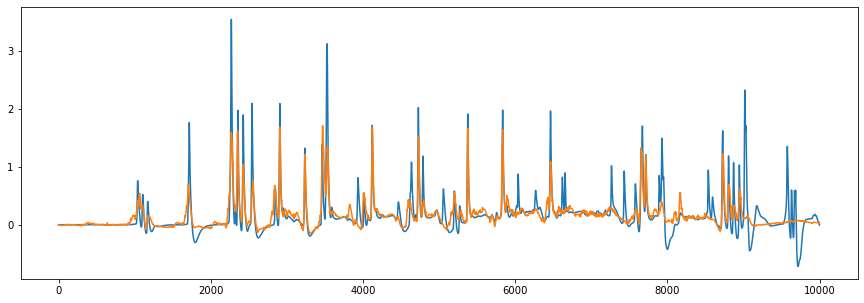

In [8]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[10000:40000][6000:16000])
plt.plot(test_V_pred.cpu().detach().numpy()[6000:16000])

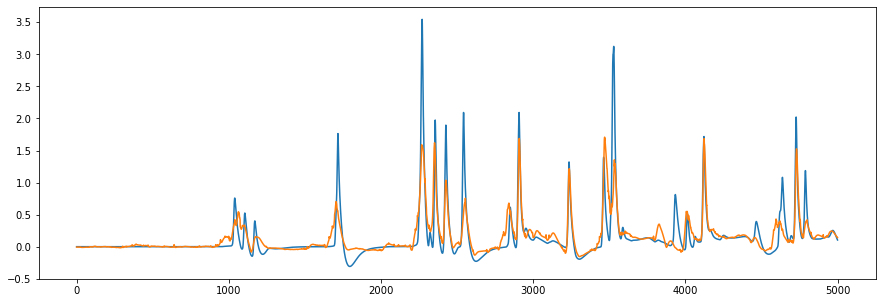

In [9]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[10000:40000][6000:16000][:5000])
plt.plot(test_V_pred.cpu().detach().numpy()[6000:16000][:5000])

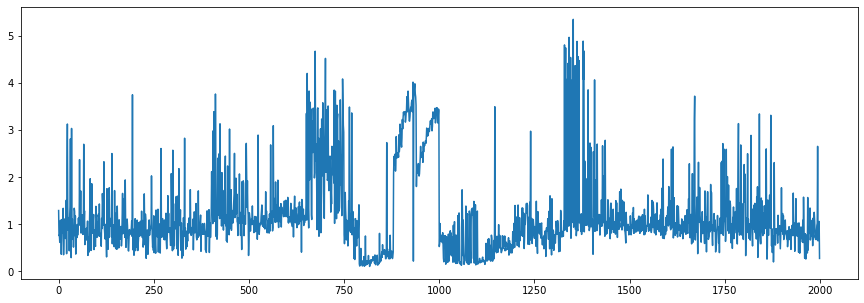

In [14]:
plt.figure(figsize = (15,5))
plt.plot(np.exp(model.E_scale.cpu().detach().numpy()))

In [16]:
C_syn_e_plot = np.zeros((E_no))

for i in range(E_no):
    idx = torch.argmax(model.C_syn_e_raw[:,i])
    C_syn_e_plot[i] = idx

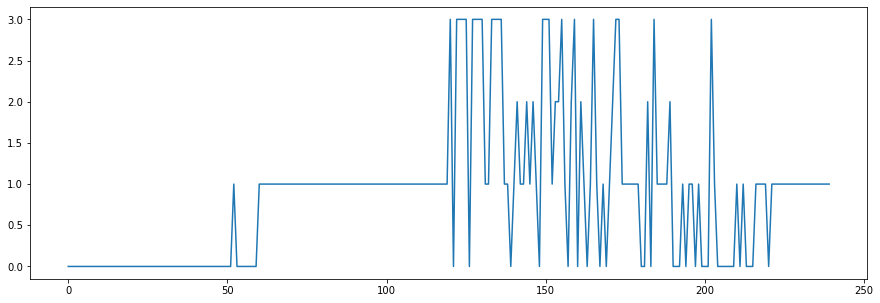

In [18]:
plt.figure(figsize = (15,5))
plt.plot(C_syn_e_plot[880:1120])